# Hyper-parameter tuning using Bayesian optimization

Bayesian hyperparameter optimization: 
Builds a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.
(https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)
(https://github.com/fmfn/BayesianOptimization/blob/master/examples/advanced-tour.ipynb)

We are now using normalized graph laplacians and a gaussian kernel for the weight matrix

## Functions needed to compute u*

In [1]:
# Parameters that are fixed (manually chosen)
g = 0.5 #Noise standard deviation
n_eig = 20

In [2]:
import autograd.numpy as np
from scipy.linalg import fractional_matrix_power

# Functions for construction of problem

# Assume Noise i.i.d. logistic random variables with mean 0
def cap_psi(X, g):
    # g - gamma
    # cdf of zero-mean logistic random var
    return np.reciprocal(np.exp(-1.0/g*X)+1.0)

def psi(X,g):
    # g - gamma
    # pdf of zero-mean logistic random var
    return 1.0/g*np.exp(-1.0/g*X)*np.reciprocal(np.exp(-1.0/g*X)+1)**2

# Weight function returned by kernel Function
# Gaussian Kernel
def weight(X, N_lst, sigma):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    sigma - parameter for K(x) = exp(-x^2/(2*sigma^2))
    '''
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    N = N_lst.size
    W = np.zeros((N,N))
    for count_i,i in enumerate(N_lst):
        for count_j, j in enumerate(N_lst):
            # kappa function as L2 norm
#             X_i = X[i]; X_j = X[j]
#             dist = 0.0
#             for ix in range(X_i.size):
#                 dist += (X_i[ix]-X_j[ix])**2
            dist_sq = np.linalg.norm(X[i]-X[j])**2
            W[count_i][count_j] = np.exp(-dist_sq/(2*sigma**2))
    return W

# Inverse of covariance
def Cov_inv(X, N_lst, alpha, tau, sigma):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    sigma - parameter for K(x) = exp(-x^2/(2*sigma^2))
    '''
    N = N_lst.size
    W = weight(X, N_lst, sigma)
    D = np.diag(W.sum(axis=1))
    # D^{-1/2} matrix
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L = D_inv_sqrt@(D - W)@D_inv_sqrt
    return fractional_matrix_power(1/tau**2*(L + tau**2*np.eye(N)), alpha).real

# truncated version of Covariance defined in [3]-(62)
def Cov_truncated(X, N_lst, alpha, tau, sigma, n_eig):
    '''
    kernel(t, r) = 1_{t<=r}(t) where t = |x_i-x_j| [3]-(61) in paper

    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use
    sigma - parameter for K(x) = exp(-x^2/(2*sigma^2))
    '''
    N = N_lst.size
    # Weight returned using perturbed kernel function k_eps(|x_i - x_j|) [1]-(61)
    W = weight(X, N_lst, sigma)
    D = np.diag(W.sum(axis=1))
    # D^{-1/2} matrix
    D = np.diag(W.sum(axis=1))
    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    L = D_inv_sqrt@(D - W)@D_inv_sqrt
    LE, LV = np.linalg.eig(L)

    CE = 1/tau**2*(LE + tau**2)**alpha
    C = np.zeros((N,N))
    for k in range(n_eig):
        C = C + 1/CE[k]*np.outer(LV[:,k],(LV[:,k].T))
    return C.real

In [3]:
import ray
from ray import tune
from ray.tune.suggest.bayesopt import BayesOptSearch

# -----------Newton's Method----------------------------------

def misfit(u, N_lst, y, Z_p, g):
    '''
    Misfit function defined in [3]-(45)
    u - vector to find
    N_lst - list of indices used
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    S = 0.0
    for Z_j in Z_p:
        u_j = np.where(N_lst == Z_j)
        S = S - np.log(cap_psi(y[Z_j]*u[u_j][0],g))
    return S

def param_probit_min(X, N_lst, y, Z_p, u, alpha, tau, sigma):

    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, alpha, tau, sigma)
    # Minimizer u for problem defined in [3]-(3)
    ret = 1/2*np.dot(u, np.matmul(C_inv,u)) + misfit(u, N_lst, y, Z_p, g)
    return ret

In [4]:
import scipy.optimize
import autograd.numpy as np
import autograd

# ------ EL method ------------------
# Array given by Fj in [3] - (12), (13)
def F_sum(N_lst, g, y, Z_p, u):
    '''
    N_lst - list of indices used
    g - gamma
    y - labels
    Z_p - Z' i.e. indices of labels
    u - vector
    '''
    N = N_lst.size
    Fj = np.zeros(N)
    for Z_j in Z_p:
        u_j = np.where(N_lst == Z_j)
        basis=np.zeros(N);basis[u_j]=1.0
        Fj = Fj + y[Z_j]*psi(y[Z_j]*u[u_j], g)/cap_psi(y[Z_j]*u[u_j], g)*basis
    return Fj

# Function needed for fsolve using EL given in [3]-(2)
def u_ast_EL(X, N_lst, y, Z_p, g, alpha, tau, sigma, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N)
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    x_0 - initial u_0 to minimize (if undefined, x_0 = vector of zeros)
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    N = N_lst.size
    if x_0: x_0 = np.zeros((N,1))
    n_eig = 20 #[3]-(62) truncation
    C = Cov_truncated(X, N_lst, alpha, tau, sigma, n_eig)
    def final(u):
    #     C = Cov(X, N, eps, alpha, tau, rval)
        return u - C@F_sum(N_lst, g, y, Z_p, u)
    return scipy.optimize.fsolve(final, x_0)

# ------- Newton's method --------------
def newton(f, x0, tol=10e-08, maxiter=50):
    '''
    f - input function
    x0 - initialization
    tol - tolerance for step size
    '''
    g = autograd.grad(f)
    h = autograd.hessian(f) # add small perturbation (black magic)

    x = x0
    for _ in range(maxiter):
        step = np.linalg.solve(h(x), -g(x))
        x = x + step
        if np.linalg.norm(step) < tol:
            break

    return x

# Returns u* using newton's method
def u_ast_Newt(X, N_lst, y, Z_p, g, alpha, tau, sigma, x_0 = True):
    '''
    X - N*3 vector containing (x, y, z) of all data (assume same size)
    N_lst - indices of X to use (Size: N) (ex. for full N, N_lst = np.arange(N))
            (if just given size N, change it to list)
    eps - gives perturbed kernel if eps != 0
    tau, alpha - parameters for covariance
    rval - threshold in kernel function
    '''
    if type(N_lst) == int:
        N_lst = np.arange(N_lst)

    C_inv = Cov_inv(X, N_lst, alpha, tau, sigma)
    def probit_min(u):
        # Minimizer u for problem defined in [3]-(3)
        return 1/2*np.dot(u, C_inv@u) + misfit(u, N_lst, y, Z_p, g)
    if x_0: x_0 = np.zeros(N_lst.size)
    return newton(probit_min, x_0)

## Set up Data

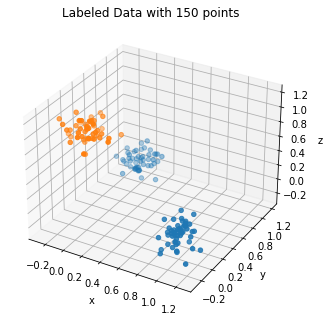

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

N_each = 50 # Number of points in each cluster
n_cluster = 3 # Number of clusters
N = N_each*n_cluster # Total number of points

mu, sigma = 0, 0.1 # mean and standard deviation
xs = np.random.normal(mu, sigma, N)
ys = np.random.normal(mu, sigma, N)
zs = np.random.normal(mu, sigma, N)

# Cluster centers: (1,0,0) (0,1,0) (0,0,1)
xs[:N_each] += 1; ys[N_each:2*N_each] += 1; zs[2*N_each:3*N_each] += 1
Data = np.array([xs,ys,zs]).T

u_dagger = np.append(np.ones(2*N_each), -1*np.ones(N_each))
Z_prime = np.array([0,20,40,50,60,80,100,130,140]) # Indices of labels
y = np.sign(u_dagger) # One label is observed within each cluster

# Display plot
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs[:2*N_each], ys[:2*N_each], zs[:2*N_each], 'r')
ax.scatter(xs[2*N_each:3*N_each], ys[2*N_each:3*N_each], zs[2*N_each:3*N_each], 'b')
ax.set_title('Labeled Data with ' + str(N) +' points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()

In [9]:
from time import perf_counter

# Practice test with Params chosen
n_eig = 20 #(62) truncation
# Initial Parameters
for tau in [.5, 1, 2]:
    for alpha in [.5, 1, 2]:
        for sigma in [.1, .5, 1]:
            print('tau: {} | alpha: {} | sigma: {}'.format(tau, alpha, sigma))
#             time_start = perf_counter()
            u_ast = u_ast_EL(Data, N, y, Z_prime, g, alpha, tau, sigma)
#             print("Runtime for EL: " + str(perf_counter() - time_start))
            pred_error =  round(sum(abs(np.sign(u_ast) - np.sign(u_dagger)))/(2*N)*100, 3)
    
#             time_start = perf_counter()
            u_ast_newt = u_ast_Newt(Data, N, y, Z_prime, g, alpha, tau, sigma)
#             print("Runtime for Newton's: " + str(perf_counter() - time_start))
            pred_error2 =  round(sum(abs(np.sign(u_ast_newt) - np.sign(u_dagger)))/(2*N)*100, 3)
            print("Error for EL: {}% | Error for Newton's: {}%".format(pred_error, pred_error2))

tau: 0.5 | alpha: 0.5 | sigma: 0.1
Error for EL: 18.0% | Error for Newton's: 0.0%
tau: 0.5 | alpha: 0.5 | sigma: 0.5
Error for EL: 6.667% | Error for Newton's: 0.0%
tau: 0.5 | alpha: 0.5 | sigma: 1
Error for EL: 15.333% | Error for Newton's: 31.333%
tau: 0.5 | alpha: 1 | sigma: 0.1
Error for EL: 15.333% | Error for Newton's: 0.0%
tau: 0.5 | alpha: 1 | sigma: 0.5
Error for EL: 0.667% | Error for Newton's: 0.0%
tau: 0.5 | alpha: 1 | sigma: 1
Error for EL: 10.0% | Error for Newton's: 31.333%
tau: 0.5 | alpha: 2 | sigma: 0.1
Error for EL: 18.0% | Error for Newton's: 0.0%
tau: 0.5 | alpha: 2 | sigma: 0.5
Error for EL: 0.0% | Error for Newton's: 0.0%
tau: 0.5 | alpha: 2 | sigma: 1
Error for EL: 33.333% | Error for Newton's: 31.333%
tau: 1 | alpha: 0.5 | sigma: 0.1
Error for EL: 22.667% | Error for Newton's: 0.0%
tau: 1 | alpha: 0.5 | sigma: 0.5
Error for EL: 16.0% | Error for Newton's: 0.0%
tau: 1 | alpha: 0.5 | sigma: 1
Error for EL: 20.667% | Error for Newton's: 10.0%
tau: 1 | alpha: 1 | s

## Trainable Function for parameter

In [10]:
#defining trainable function that minimizes probit function
def trainable(config):
    maxiter = 50
    for __ in range(maxiter):
        u = np.random.normal(mu, sigma, N)
        result = param_probit_min(Data, N, y, Z_prime, u, config["alpha"], 
                   config["tau"], config["sigma"])
        tune.report(score = result)
        # Define the search space
config = {
    "alpha": tune.uniform(0, 3),
    "tau": tune.uniform(0, 3),
    "sigma": tune.uniform(0, 1.5),
}

In [11]:
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.bayesopt import BayesOptSearch

bayesopt = BayesOptSearch(metric = "score", mode="min")
analysis = tune.run(trainable, config = config, search_alg=bayesopt, num_samples=5, verbose = 0)


2021-12-06 16:21:56,300	WARNING function_runner.py:563 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-12-06 16:21:56,320	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-12-06 16:21:56,321	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.
2021-12-06 16:21:56,322	WARNING bayesopt.py:397 -- BayesOpt does not support specific sampling methods. The Uniform sampler will be dropped.


In [12]:
# Get a dataframe for the last reported results of all of the trials
df_results = analysis.results_df

# Get a dataframe for the max accuracy seen for each trial
df = analysis.dataframe(metric="score", mode="min")

# Get a dict mapping {trial logdir -> dataframes} for all trials in the experiment.
all_dataframes = analysis.trial_dataframes

# Get a list of trials
trials = analysis.trials

/opt/anaconda3/lib/python3.8/site-packages/ray/tune/analysis/experiment_analysis.py:565: UserWarning: Dataframes will use '/' instead of '.' to delimit nested result keys in future versions of Ray. For forward compatibility, set the environment variable TUNE_RESULT_DELIM='/'
  warnings.warn(


In [13]:
analysis.get_best_config('score', 'min')

{'alpha': 2.1242177333881367,
 'tau': 2.909729556485983,
 'sigma': 0.03087674144370367}

In [14]:
# Not bayesian
config = {
    "alpha": tune.uniform(0, 6),
    "tau": tune.uniform(0, 6),
    "sigma": tune.uniform(0, 1.5),
}
analysis2 = tune.run(trainable, config = config, mode = 'min', metric = 'score', num_samples=5, verbose = 0)


In [15]:
best_trial = analysis2.best_trial  # Get best trial
best_config = analysis2.best_config  # Get best trial's hyperparameters
best_logdir = analysis2.best_logdir  # Get best trial's logdir
best_result = analysis2.best_result  # Get best trial's last results
best_result_df = analysis2.best_result_df  # Get best result as pandas dataframe

In [16]:
best_config

{'alpha': 2.493619389718994,
 'tau': 4.406432253794166,
 'sigma': 0.30008330997972993}

# Now using bayesian optimization with kernel-flow methods

In [23]:
# Using Kernel Flow method to approximate parameters

# Return randomly selected half data indices from N that includes half of
# labeled data
# Follows from [1]
def select_Nf(N, Z_prime):
    '''
    N - (int) number of elements
    Z_prime - indices of labeled data
    '''
    N_f = int((N-Z_prime.size)/2) # Must be <= N
    half_Z = int(Z_prime.size/2+1) # half of labels

    # Randomly selected indices N_f and N_c used for X,Y,Z
    # Always need to include Z' or else cant compute
    N_f_i = np.random.choice(N, N_f, replace=False)
    Z_half= np.random.choice(Z_prime, half_Z, replace=False)
    for z in Z_half:
        if z not in N_f_i:
            N_f_i = np.append(N_f_i, z)

    N_f = N_f_i.size
    return N_f_i, Z_half

# Follows rho expression given in [2]-(6)
def rho_EL(alpha, tau, sigma):
    '''
    theta - parameters to optimize (g, alpha, tau, eps, rval)
    X - whole data (not just half)
    N - (int) number of elements
    Z_prime - indices of labeled data
    y - labels (of Z_prime)
    '''
    # g = 0.15; alpha = 1.; tau = 1.;
    # eps, rval= theta

    N_f_i, Z_half = select_Nf(N, Z_prime)
    uast = u_ast_EL(Data, N, y, Z_prime, g, alpha, tau, sigma)
    uast_tild = u_ast_EL(Data, N_f_i, y, Z_half, g, alpha, tau, sigma)

    # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
    # loop over each valid N_f_i
    num = 0.0
    denom = 0.0
    for u_i, nf_i in enumerate(N_f_i):
        num += (uast_tild[u_i] - uast[nf_i])**2
        denom += uast[nf_i]**2
    return - num/denom

# Follows rho expression given in [2]-(6)
def rho_Newt(alpha, tau, sigma):
    '''
    theta - parameters to optimize (g, alpha, tau, eps, rval)
    X - whole data (not just half)
    N - (int) number of elements
    Z_prime - indices of labeled data
    y - labels (of Z_prime)
    '''
    # g = 0.15; alpha = 1.; tau = 1.;
    # eps, rval= theta

    N_f_i, Z_half = select_Nf(N, Z_prime)
    uast = u_ast_Newt(Data, N, y, Z_prime, g, alpha, tau, sigma)
    uast_tild = u_ast_Newt(Data, N_f_i, y, Z_half, g, alpha, tau, sigma)

    # Compute |uast-uast_tild|^2/|uast|^2 using L2 norm
    # loop over each valid N_f_i
    num = 0.0
    denom = 0.0
    for u_i, nf_i in enumerate(N_f_i):
        num += (uast_tild[u_i] - uast[nf_i])**2
        denom += uast[nf_i]**2
    return - num/denom

In [40]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

zeros = 1e-7
pbounds = {'sigma': (zeros,1.0), 'alpha':(zeros,4), 'tau':(zeros,4)}
optimizer_EL = BayesianOptimization(
    f=rho_EL,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)
print("Optimizer for Euler-Lagrange equations")
# flip (rho) minimize --> (- rho) maximize
optimizer_EL.maximize(
    init_points=3,
    n_iter=10,
)

optimizer_Newt = BayesianOptimization(
    f=rho_Newt,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)
print("Optimizer for Newton's Method")
# flip (rho) minimize --> (- rho) maximize
optimizer_Newt.maximize(
    init_points=3,
    n_iter=10,
)


Optimizer for Euler-Lagrange equations
|   iter    |  target   |   alpha   |   sigma   |    tau    |
-------------------------------------------------------------
|  1        | -0.231    |  1.668    |  0.7203   |  0.000457 |
|  2        | -0.08105  |  1.209    |  0.1468   |  0.3694   |
|  3        | -0.388    |  0.745    |  0.3456   |  1.587    |
|  4        | -0.147    |  1.367    |  0.2126   |  0.4125   |
|  5        | -2.0      |  0.8842   |  1e-07    |  0.131    |
|  6        | -0.5261   |  1.192    |  0.168    |  0.6699   |
|  7        | -0.6145   |  0.9101   |  0.1556   |  3.789    |
|  8        | -0.1671   |  2.905    |  0.7286   |  0.7788   |
|  9        | -0.3329   |  1.169    |  0.4246   |  0.3435   |
|  10       | -0.5879   |  3.822    |  0.6641   |  1.883    |
|  11       | -0.2076   |  1.955    |  0.8412   |  3.916    |
|  12       | -0.07776  |  1.391    |  0.2102   |  0.1398   |
|  13       | -0.1237   |  1.607    |  0.4142   |  0.1872   |
Optimizer for Newton's Method
|

In [41]:
from time import perf_counter

if __name__ == "__main__":
# Initial Parameters
    sigma = optimizer_EL.max['params']['sigma']
    tau = optimizer_EL.max['params']['tau']
    alpha = optimizer_EL.max['params']['alpha']


    time_start = perf_counter()
    u_ast = u_ast_EL(Data, N, y, Z_prime, g, alpha, tau, sigma)
    print("Runtime for EL: " + str(perf_counter() - time_start))
    pred_error =  (sum(abs(np.sign(u_ast) - np.sign(u_dagger)))/(2*N)*100)
    print("Error for EL: " + str(pred_error))


    tau = optimizer_Newt.max['params']['tau']
    alpha = optimizer_Newt.max['params']['alpha']
    sigma = optimizer_Newt.max['params']['sigma']
    time_start = perf_counter()
    u_ast_newt = u_ast_Newt(Data, N, y, Z_prime, g, alpha, tau, sigma)
    print("Runtime for Newton's: " + str(perf_counter() - time_start))
    pred_error =  (sum(abs(np.sign(u_ast_newt) - np.sign(u_dagger)))/(2*N)*100)
    print("Error for Newton's: " + str(pred_error))

Runtime for EL: 0.5896685259999686
Error for EL: 0.0
Runtime for Newton's: 1.8794445530000985
Error for Newton's: 0.0


In [42]:
optimizer_EL.max['params']

{'alpha': 1.3913000111176397,
 'sigma': 0.21022928712995093,
 'tau': 0.13979266501648463}

In [43]:
optimizer_Newt.max['params']

{'alpha': 1.5033615854732953,
 'sigma': 0.7898785560381721,
 'tau': 3.0977876309364594}